### Imports

In [ ]:
import numpy as np
from sympy import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import timeit
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath('../..'))

from neck_brace_kinematics import forward_kinematics, inverse_kinematics, evaluate_ee_fk

### Time testing Forward and Inverse Kinematics

In [5]:
# Example test for the forward_kinematics function
sample_joint_values = [.07, .162, .24, 1.9]

execution_time = timeit.timeit(lambda: forward_kinematics(*sample_joint_values), number=1)
fk_result = forward_kinematics(*sample_joint_values, xtol=1e-6)
print("Forward kinematics result:", fk_result)
print(f"Execution time: {execution_time:.6f} seconds")

### store vars for plotting - run cell below to plot
d1_val, d2_val, d3_val, theta2_val = sample_joint_values
alpha_val, beta_val, gamma_val, z_val, theta1_val, gamma1_1_val, gamma2_1_val, gamma1_2_val, gamma2_2_val, theta3_val, gamma1_3_val, gamma2_3_val = fk_result

Forward kinematics result: [ 0.46788142  0.44354669  1.0884981   0.03071768  1.97751407 -0.95788631
 -0.15801869 -0.90780785  0.61347586  2.13885798 -1.55930863 -0.77271999]
Execution time: 0.019214 seconds


In [4]:
# Example test for the inverse_kinematics function
sample_pose = [np.deg2rad(55),np.deg2rad(0),np.deg2rad(0), 0.150]
initial_guess = [0.2, 0.2, 0.2, 1.75, np.deg2rad(100), 0, 0, 0, 0, np.deg2rad(80), 0, 0]

execution_time = timeit.timeit(lambda: inverse_kinematics(*sample_pose), number=1)
ik_result = inverse_kinematics(*sample_pose, initial_guess=initial_guess)
print("Inverse kinematics result:", ik_result)
print(f"Execution time: {execution_time:.6f} seconds")

### store vars for plotting - run cell below to plot
alpha_val, beta_val, gamma_val, z_val = sample_pose
d1_val, d2_val, d3_val, theta2_val, theta1_val, gamma1_1_val, gamma2_1_val, gamma1_2_val, gamma2_2_val, theta3_val, gamma1_3_val, gamma2_3_val = ik_result

Inverse kinematics result: [ 0.25852372  0.22031186  0.25852027  1.56823264  1.41853532 -0.79740809
 -0.9662539  -0.08115226 -0.46719701  1.72304709 -0.79733207 -0.96625392]
Execution time: 0.007009 seconds


/home/darren/Desktop/neckbot-4dof/neck_brace_kinematics.py:189: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  soln = fsolve(constraints, initial_guess, xtol=xtol)


In [28]:
from visualize_robot import visualize_robot

# Create a plot with the same values as in your original code
fig = visualize_robot(
    alpha_val, beta_val, gamma_val, z_val,
    d1_val, d2_val, d3_val, theta2_val,
    theta1_val, gamma1_1_val, gamma2_1_val,
    gamma1_2_val, gamma2_2_val,
    theta3_val, gamma1_3_val, gamma2_3_val,
)

fig.update_layout(
    scene_camera=dict(
        eye=dict(x=1.5, y=.5, z=1.0) 
    )
)

fig.show()

## Sweeping through the joint space

Here we can adjust the joint ranges to cover every permutation of robot configuarations. 10000 exploration points can take around 80 seconds to compute on an AMD Ryzen 9 6900HS Creator Edition (16) cpu

to change the robot's fixed geometric parameters, please edit `geometric_params` dictionary in `neck_brace_kinematics.py`


In [5]:
# Define joint limits
d1_range = np.linspace(.07, .24, 10)  # 10 points from 150 to 200
d2_range = np.linspace(.162, .33, 10)
d3_range = np.linspace(.07, .24, 10)
theta2_range = np.linspace(1.45, 1.9, 10)

# Create empty arrays to store the results
num_points = len(d1_range) * len(d2_range) * len(d3_range) * len(theta2_range)
joint_vectors = np.zeros((num_points, 4))
fk_results = np.zeros((num_points, 4))

# crude way of getting all permutations of joint angles
idx = 0
for j1 in d1_range:
    for j2 in d2_range:
        for j3 in d3_range:
            for j4 in theta2_range:
                joint_vector = [j1, j2, j3, j4]
                joint_vectors[idx] = joint_vector
                
                # Calculate forward kinematics
                fk_result = forward_kinematics(*joint_vector)
                
                # Extract position (x, y, z)
                fk_results[idx] = fk_result[:4]
                
                idx += 1

print(f"Generated {num_points} points for joint space exploration")
print(f"Shape of joint vectors: {joint_vectors.shape}")
print(f"Shape of end effector positions: {fk_results.shape}")

/home/darren/Desktop/adv_robotics/workspace_analysis/neck_brace_kinematics.py:171: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.

/home/darren/Desktop/adv_robotics/workspace_analysis/neck_brace_kinematics.py:171: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.



Generated 10000 points for joint space exploration
Shape of joint vectors: (10000, 4)
Shape of end effector positions: (10000, 4)


In [6]:
# Create an array to store the average positions of E1 and E3
avg_positions = np.zeros((num_points, 3))

# Calculate the end effector positions and average of E1 and E3
for i in range(num_points):
    E1_ee_val, E2_ee_val, E3_ee_val, A_val = evaluate_ee_fk(*fk_results[i])
    
    # Convert to numpy arrays and flatten
    E1_ee_eval = E1_ee_val.flatten().astype(np.float64)
    E3_ee_eval = E3_ee_val.flatten().astype(np.float64)
    
    # Calculate average position of E1 and E3
    avg_positions[i] = 0.5 * (E1_ee_eval + E3_ee_eval)

In [20]:
import plotly.graph_objects as go
import plotly.express as px

home_pose = [0, 0, 0, 0.150]  # Define the home pose for the end effector
ik_home = inverse_kinematics(*home_pose)

# Create a scatter3d trace for the average positions
fig = visualize_robot(*home_pose, *ik_home, width=None, height=None)

# Add the scatter points with color based on distance from z-axis
fig.add_trace(go.Scatter3d(
    x=avg_positions[:, 0],
    y=avg_positions[:, 1],
    z=avg_positions[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=(avg_positions[:, 0]**2 + avg_positions[:, 1]**2)**0.5,  # heatmap by distance from z-axis
        colorscale='jet',
        opacity=0.2,
        colorbar=dict(title='Distance from z-axis')
    ),
    name='End Effector Positions'
))

# Set the layout
fig.update_layout(margin=dict(l=0, r=50, b=0, t=30))

# Show the figure
fig.show()

# Save the figure as an HTML file
fig.write_html("neck_brace_joint_space_exploration.html")

## End-effector space sweep and animation 

implementing sweep of principle rotation directions

In [42]:
# Define sweep ranges
alpha_range = np.linspace(np.deg2rad(-41), np.deg2rad(41), 100)  # 100 points from -41 to 41 degrees
beta_range = np.linspace(np.deg2rad(-37), np.deg2rad(80), 100)
gamma_range = np.linspace(np.deg2rad(-30), np.deg2rad(30), 100)

# Create empty arrays to store the results
num_points = len(alpha_range) + len(beta_range) + len(gamma_range)
poses = np.zeros((num_points, 4))
ik_results = np.zeros((num_points, 12))

In [43]:
idx = 0
initial_guess = [0.2, 0.2, 0.2, 1.75, np.deg2rad(100), 0, 0, 0, 0, np.deg2rad(80), 0, 0]

for alpha in alpha_range:
    pose = np.array([alpha, 0, 0, 0.150])
    poses[idx, :] = pose
    
    ik_result = inverse_kinematics(*pose, initial_guess=initial_guess)
    initial_guess = ik_result  # Update initial guess for next iteration

    ik_results[idx, :] = ik_result
    idx += 1

initial_guess = [0.2, 0.2, 0.2, 1.75, np.deg2rad(100), 0, 0, 0, 0, np.deg2rad(80), 0, 0]
for beta in beta_range:
    pose = np.array([0, beta, 0, 0.150])
    poses[idx, :] = pose
    
    ik_result = inverse_kinematics(*pose, initial_guess=initial_guess)
    initial_guess = ik_result  # Update initial guess for next iteration

    ik_results[idx, :] = ik_result
    idx += 1

initial_guess = [0.2, 0.2, 0.2, 1.75, np.deg2rad(100), 0, 0, 0, 0, np.deg2rad(80), 0, 0]
for gamma in gamma_range:
    pose = np.array([0, 0, gamma, 0.150])
    poses[idx, :] = pose

    ik_result = inverse_kinematics(*pose, initial_guess=initial_guess)
    initial_guess = ik_result  # Update initial guess for next iteration

    ik_results[idx, :] = ik_result
    idx += 1


In [ ]:
import imageio
import kaleido # requirement for plotly
kaleido.get_chrome_sync() # kaleido needs to sync with Chrome for rendering images
import io

frames = []
    
pbar = tqdm(total=num_points, desc="Processing frames", unit="frame")
for i in range(num_points):
    alpha_val, beta_val, gamma_val, z_val = poses[i]
    d1_val, d2_val, d3_val, theta2_val, theta1_val, gamma1_1_val, gamma2_1_val, gamma1_2_val, gamma2_2_val, theta3_val, gamma1_3_val, gamma2_3_val = ik_results[i]
    
    fig = visualize_robot(
        alpha_val, beta_val, gamma_val, z_val,
        d1_val, d2_val, d3_val, theta2_val,
        theta1_val, gamma1_1_val, gamma2_1_val,
        gamma1_2_val, gamma2_2_val,
        theta3_val, gamma1_3_val, gamma2_3_val,
    )
    

    if i < len(alpha_range):
        fig.update_layout(
            scene_camera=dict(
                eye=dict(x=1.5, y=.5, z=1.0) 
            )
        )
    elif i < len(beta_range) + len(alpha_range):
        fig.update_layout(
            scene_camera=dict(
            eye=dict(x=2.0, y=0, z=0.2) 
            )
        )
    else:
        fig.update_layout(
            scene_camera=dict(
                eye=dict(x=0, y=2.0, z=1.0)  # Camera positioned along +x axis, looking toward origin
            )
        )

    img_bytes = fig.to_image(format="png", engine="kaleido")
    
    image = imageio.v2.imread(io.BytesIO(img_bytes))
    frames.append(image)

    pbar.update(1)


duration = 0.02
imageio.mimsave('axial_rotation.gif', frames[:len(alpha_range)], duration=duration, loop=0)
imageio.mimsave('flexion_extension.gif', frames[len(alpha_range): len(alpha_range) + len(beta_range)], duration=duration, loop=0)
imageio.mimsave('lateral_bending.gif', frames[len(alpha_range) + len(beta_range): len(alpha_range) + len(beta_range) + len(gamma_range)], duration=duration, loop=0)


Processing frames:   0%|          | 0/300 [00:00<?, ?frame/s]

d1: min = 0.0542, max = 0.2403
d2: min = 0.0738, max = 0.3078
d3: min = 0.0542, max = 0.2403
theta2: min = 1.4290, max = 1.9202


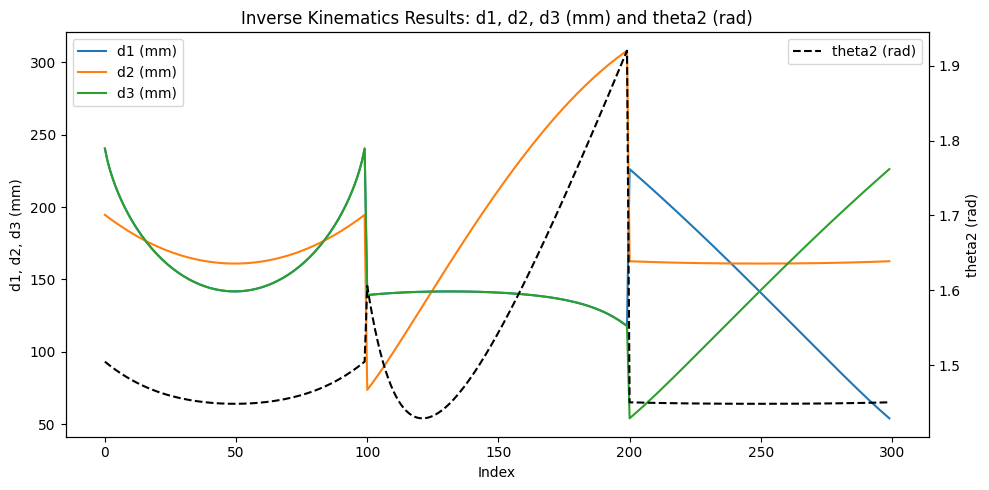

In [ ]:
## cross checking inverse kinematics with marlow's code
# Get the min and max values for d1, d2, d3, and theta2 from the first 4 columns of ik_results
d1_min, d1_max = ik_results[:, 0].min(), ik_results[:, 0].max()
d2_min, d2_max = ik_results[:, 1].min(), ik_results[:, 1].max()
d3_min, d3_max = ik_results[:, 2].min(), ik_results[:, 2].max()
theta2_min, theta2_max = ik_results[:, 3].min(), ik_results[:, 3].max()

print(f"d1: min = {d1_min:.4f}, max = {d1_max:.4f}")
print(f"d2: min = {d2_min:.4f}, max = {d2_max:.4f}")
print(f"d3: min = {d3_min:.4f}, max = {d3_max:.4f}")
print(f"theta2: min = {theta2_min:.4f}, max = {theta2_max:.4f}")


fig, ax1 = plt.subplots(figsize=(10, 5))

x = np.arange(ik_results.shape[0])

# Plot d1, d2, d3 (convert to mm)
ax1.plot(x, ik_results[:, 0] * 1000, label='d1 (mm)')
ax1.plot(x, ik_results[:, 1] * 1000, label='d2 (mm)')
ax1.plot(x, ik_results[:, 2] * 1000, label='d3 (mm)')
ax1.set_xlabel('Index')
ax1.set_ylabel('d1, d2, d3 (mm)')
ax1.legend(loc='upper left')

# Create a second y-axis for theta2 (radians)
ax2 = ax1.twinx()
ax2.plot(x, ik_results[:, 3], 'k--', label='theta2 (rad)')
ax2.set_ylabel('theta2 (rad)')
ax2.legend(loc='upper right')

plt.title('Inverse Kinematics Results: d1, d2, d3 (mm) and theta2 (rad)')
plt.tight_layout()
plt.show()